In [ ]:
!pip install prophet

In [1]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
import numpy as np
import os
import time
from prophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import plot
from IPython.display import clear_output

In [2]:
region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
holidays_key = 'holidays_events.csv'
oil_key = 'oil.csv'

holiday = 's3://{}/{}/{}'.format(bucket, prefix, holidays_key)
oil = 's3://{}/{}/{}'.format(bucket, prefix, oil_key)

holidays = pd.read_csv(holiday)
oils = pd.read_csv(oil)



In [3]:
df = pd.concat([oils, holidays])

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df['month'] = pd.DatetimeIndex(df.index).month
df['year'] = pd.DatetimeIndex(df.index).year
df['day'] = pd.DatetimeIndex(df.index).day

df = df.sort_index()
df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24


# EDA

In [4]:
corr_matrix = df.copy()
locale = pd.get_dummies(corr_matrix['locale'])
types = pd.get_dummies(corr_matrix['type'])
locale_name = pd.get_dummies(corr_matrix['locale_name'])
transfer = pd.get_dummies(corr_matrix['transferred'], drop_first=True)

corr_matrix = pd.concat([corr_matrix, locale], axis=1)
corr_matrix = pd.concat([corr_matrix, types], axis=1)
corr_matrix = pd.concat([corr_matrix, locale_name], axis=1)
corr_matrix = pd.concat([corr_matrix, transfer], axis=1)

corr_matrix = corr_matrix.drop(['locale', 'type', 'locale_name', 'transferred', 'description'], axis=1)
corr = corr_matrix.corr()
corr

,dcoilwtico,month,year,day,Local,National,Regional,Additional,Bridge,Event,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
dcoilwtico,1.000000,0.003173,-0.833855,-0.007173,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.003173,1.000000,-0.138870,0.022682,0.126706,0.097119,0.052045,0.227619,0.050019,-0.045022,...,-0.064560,-0.028387,0.062045,0.144898,-0.014595,0.098218,0.080132,0.007786,0.080132,0.021710
year,-0.833855,-0.138870,1.000000,0.005138,-0.053876,0.006309,-0.028601,-0.030651,-0.040899,0.064924,...,-0.014218,-0.014218,-0.014218,-0.008573,-0.020146,-0.014218,-0.014218,-0.014218,-0.014218,0.057277
day,-0.007173,0.022682,0.005138,1.000000,-0.033857,-0.000787,-0.080513,0.105935,0.012145,0.007151,...,-0.094052,-0.024338,-0.059195,-0.100778,0.024784,0.045377,-0.059195,-0.087081,-0.066167,-0.015552
Local,NaN,0.126706,-0.053876,-0.033857,1.000000,-0.115753,-0.040848,0.073588,-0.018531,-0.063053,...,0.189167,0.189167,0.189167,0.279072,0.268038,0.189167,-0.020306,0.189167,-0.020306,0.070164
National,NaN,0.097119,0.006309,-0.000787,-0.115753,1.000000,-0.044048,0.393070,0.160089,0.544722,...,-0.021897,-0.021897,-0.021897,-0.032304,-0.031026,-0.021897,-0.021897,-0.021897,-0.021897,0.155369
Regional,NaN,0.052045,-0.028601,-0.080513,-0.040848,-0.044048,1.000000,-0.022860,-0.007052,-0.023994,...,-0.007727,-0.007727,-0.007727,-0.011400,-0.010949,-0.007727,0.497111,-0.007727,0.497111,-0.010949
Additional,NaN,0.227619,-0.030651,0.105935,0.073588,0.393070,-0.022860,1.000000,-0.010370,-0.035287,...,-0.011364,-0.011364,-0.011364,0.221129,-0.016102,-0.011364,-0.011364,-0.011364,-0.011364,-0.016102
Bridge,NaN,0.050019,-0.040899,0.012145,-0.018531,0.160089,-0.007052,-0.010370,1.000000,-0.010885,...,-0.003505,-0.003505,-0.003505,-0.005171,-0.004967,-0.003505,-0.003505,-0.003505,-0.003505,-0.004967
Event,NaN,-0.045022,0.064924,0.007151,-0.063053,0.544722,-0.023994,-0.035287,-0.010885,1.000000,...,-0.011928,-0.011928,-0.011928,-0.017596,-0.016901,-0.011928,-0.011928,-0.011928,-0.011928,-0.016901


Text(0.5, 1.0, 'Correlation heatmap')

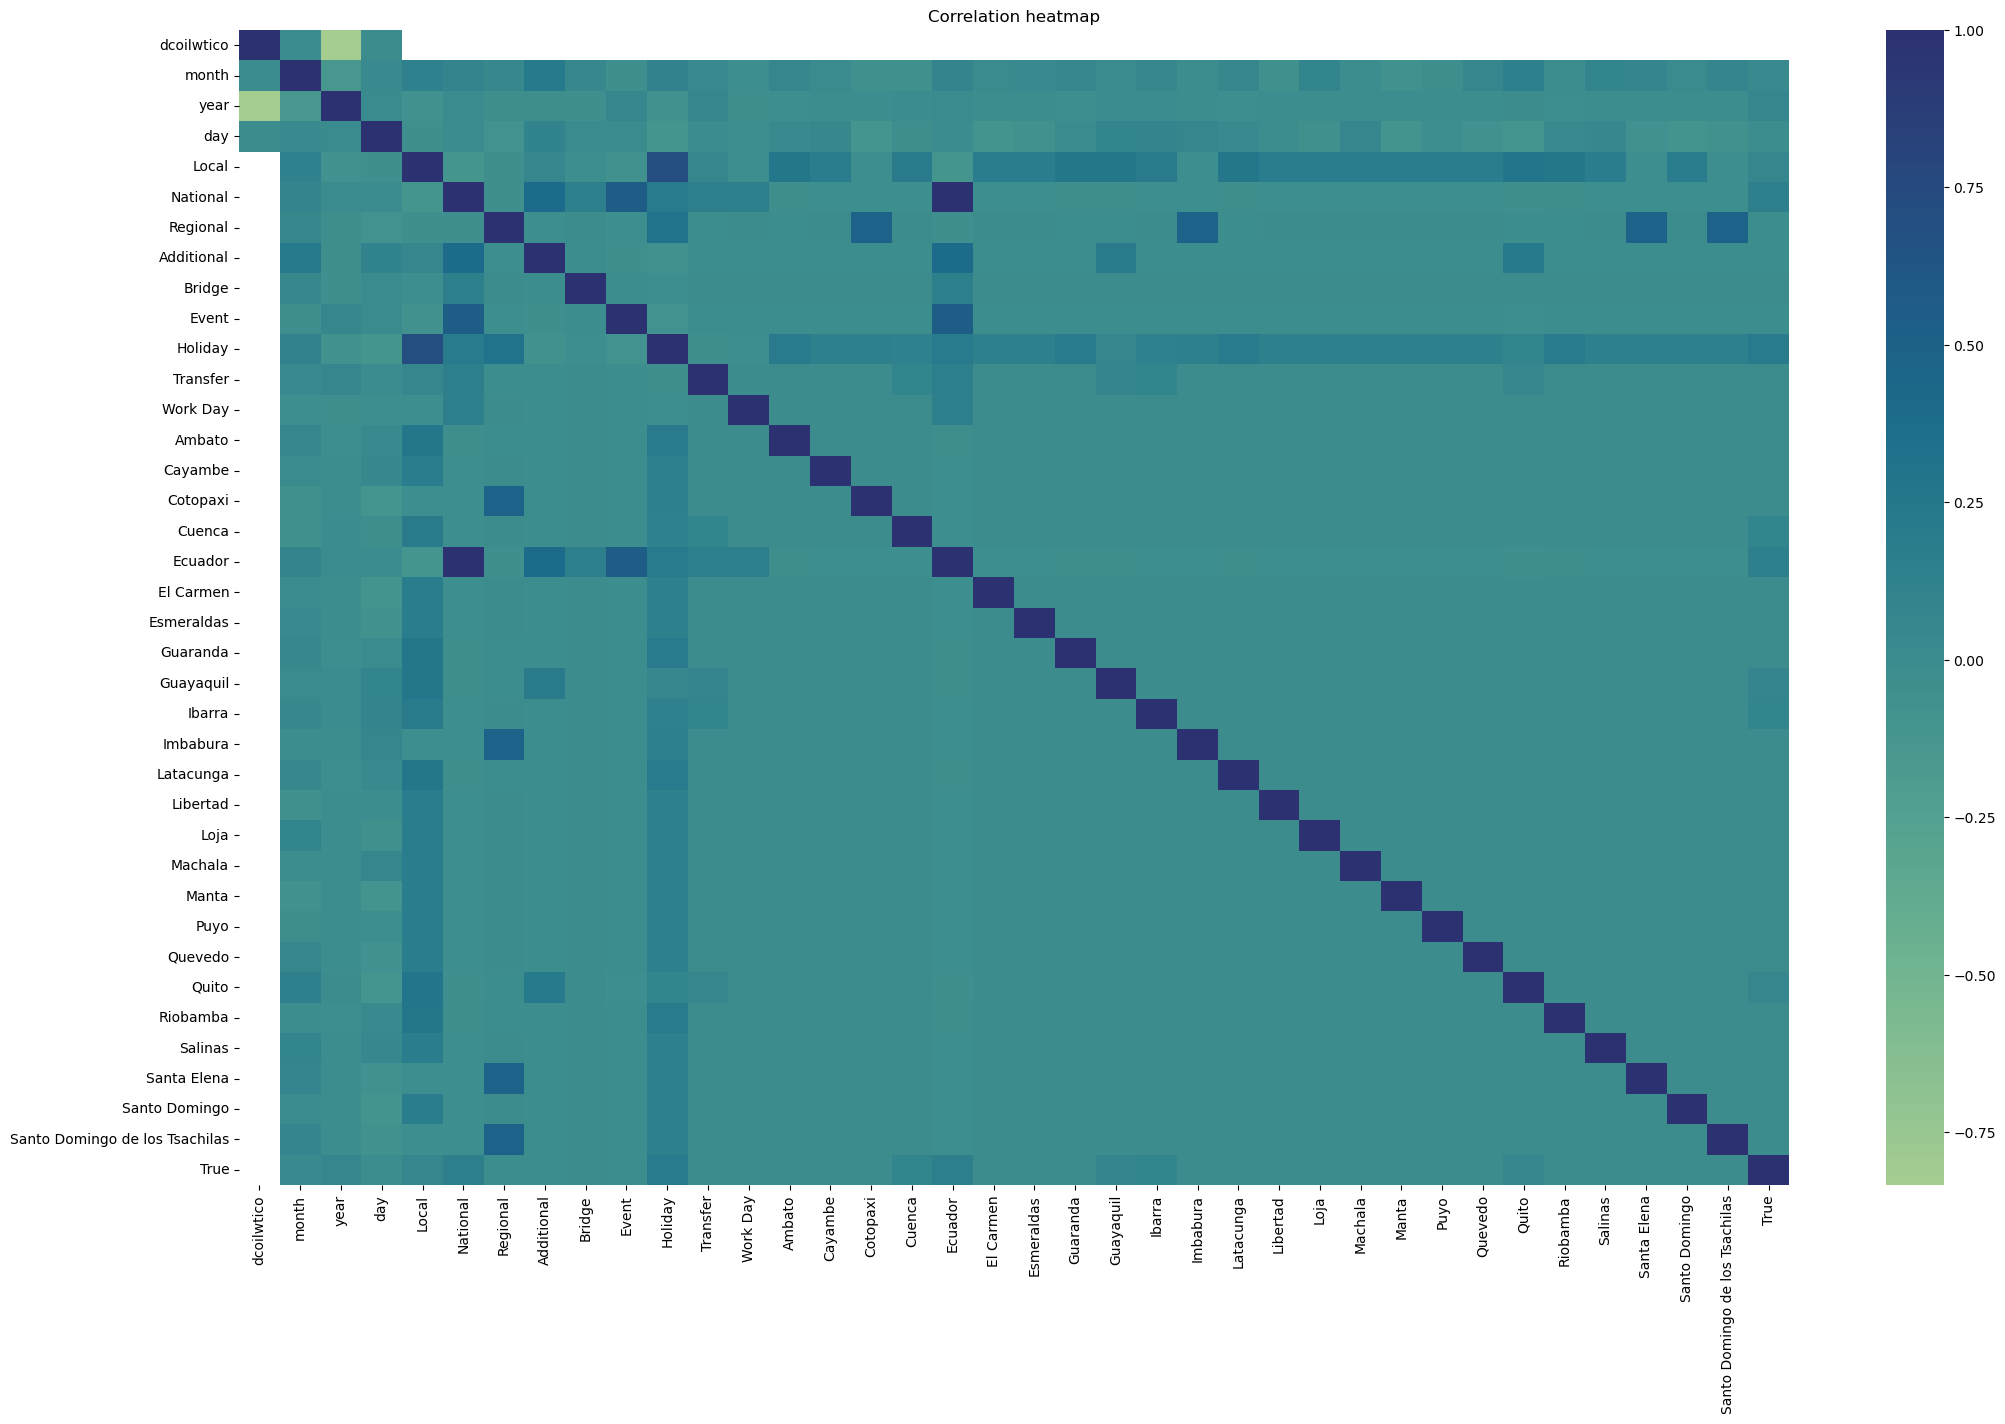

In [5]:
plt.figure(figsize=(25,15))
sns.heatmap(data=corr, cmap='crest')
plt.title('Correlation heatmap')

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24


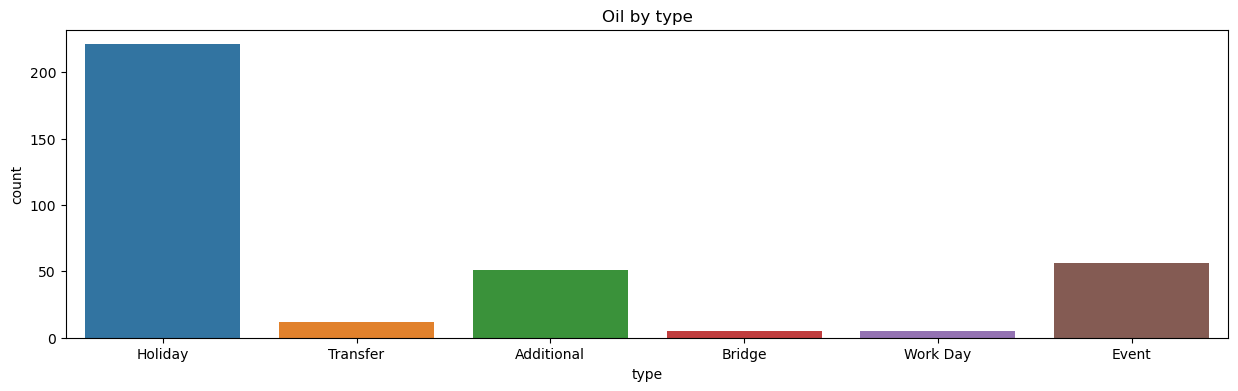

In [6]:
plt.figure(figsize=(15,4))
sns.countplot(data=df, x='type')
plt.title('Oil by type')
df

Text(0.5, 1.0, 'Oil by day')

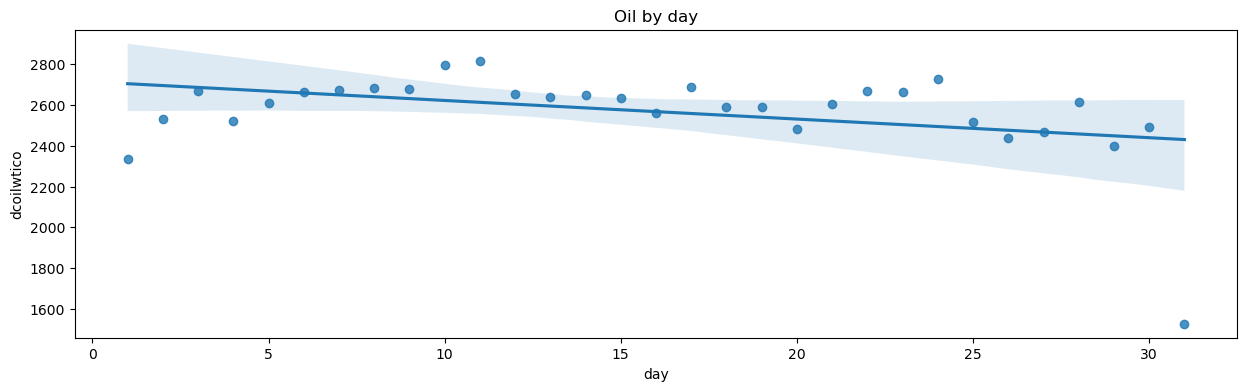

In [7]:
oil_by_day = df.groupby('day')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_day.index, y=oil_by_day)
plt.title('Oil by day')

Text(0.5, 1.0, 'Oil by day')

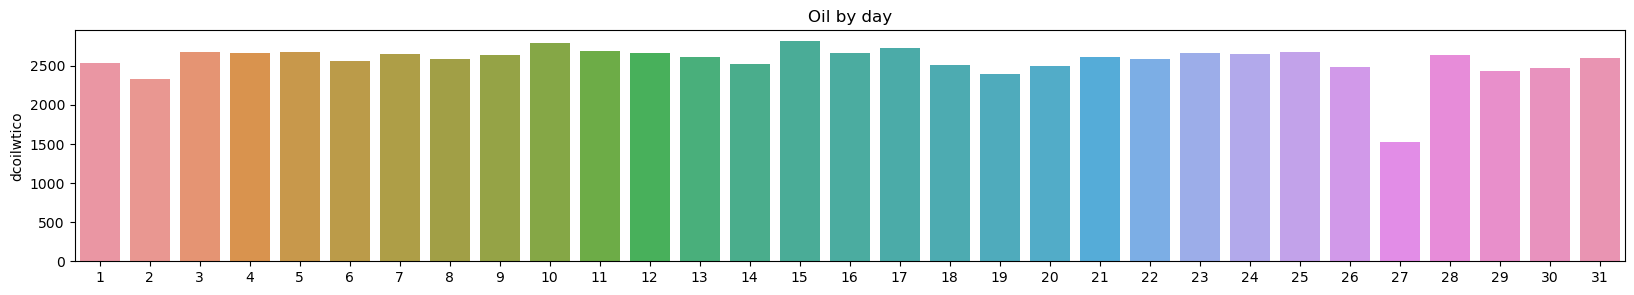

In [8]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['day'].unique(), y=oil_by_day)
plt.title('Oil by day')

Text(0.5, 1.0, 'Oil by month')

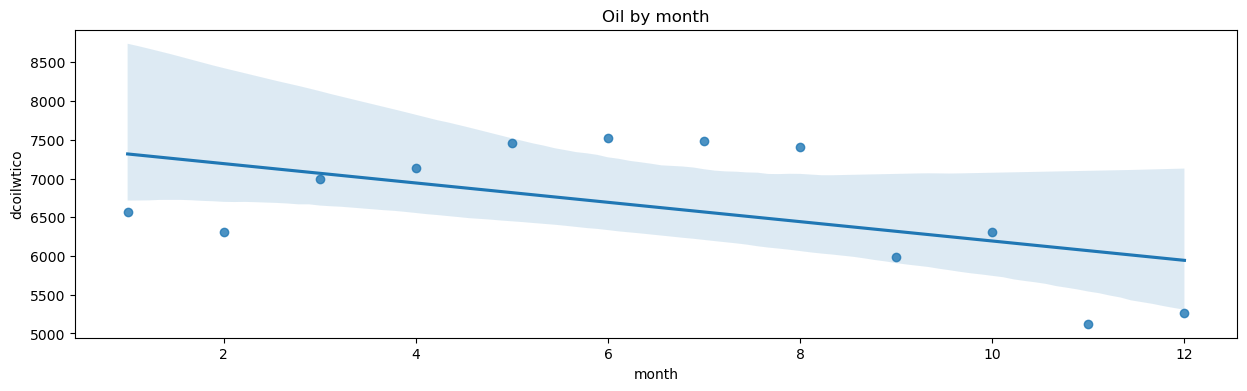

In [9]:
oil_by_month = df.groupby('month')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_month.index, y=oil_by_month)
plt.title('Oil by month')

Text(0.5, 1.0, 'Oil by month')

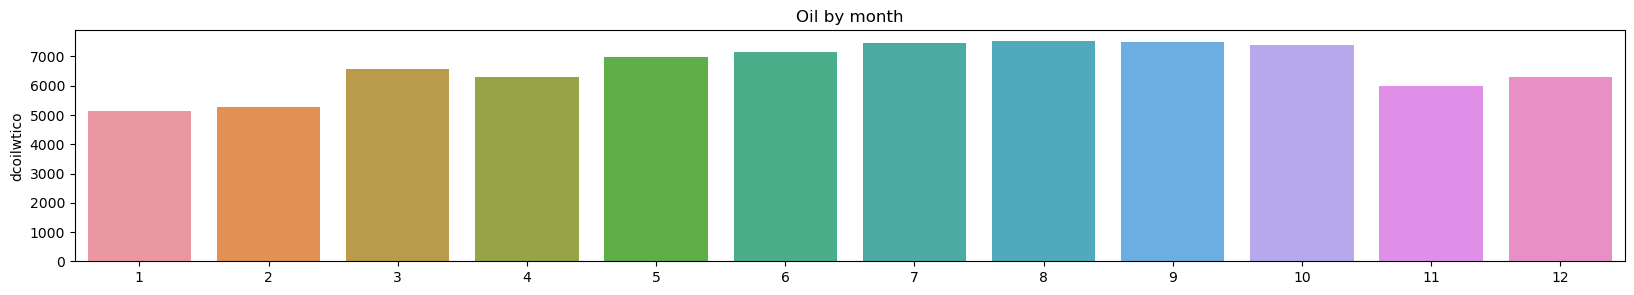

In [10]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['month'].unique(), y=oil_by_month)
plt.title('Oil by month')

Text(0.5, 1.0, 'Oil in 2013')

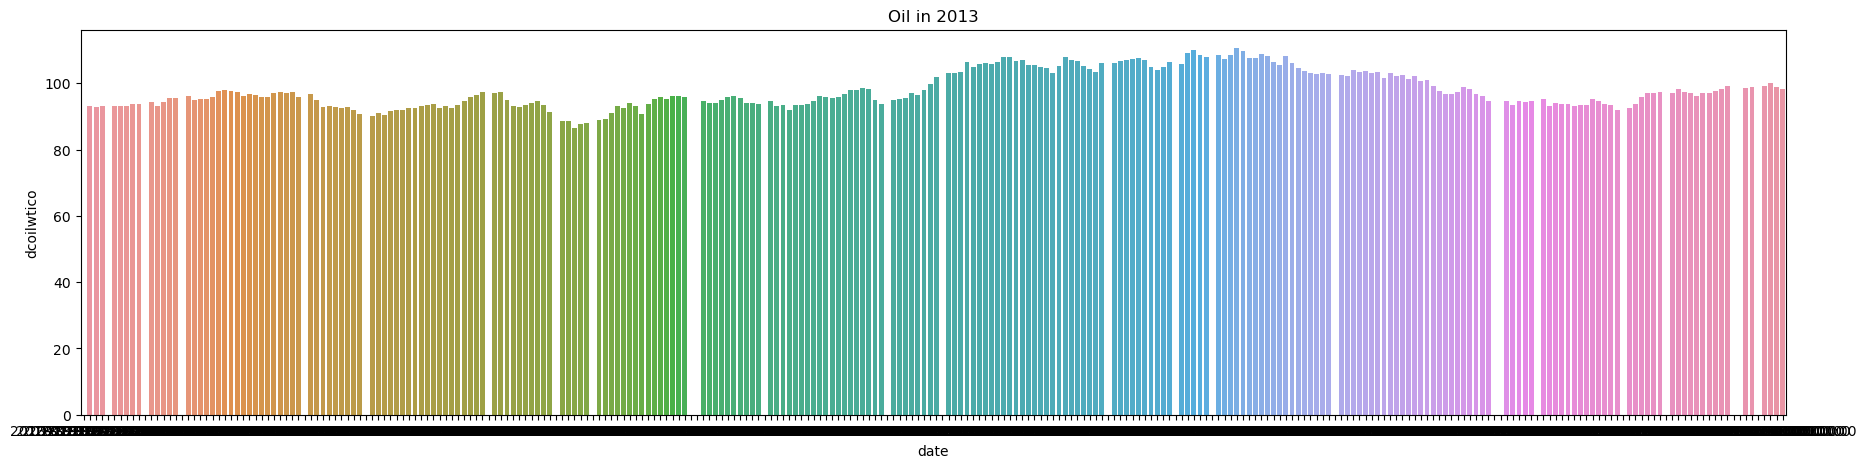

In [11]:
plt.figure(figsize=(22,5))

year = df[df['year'] == 2013]

oil_per_2013_year = year.groupby(['date'])['dcoilwtico'].sum()

sns.barplot(x=oil_per_2013_year.index.unique(), y=oil_per_2013_year)
plt.title('Oil in 2013')

Text(0.5, 1.0, 'Oil in 2017')

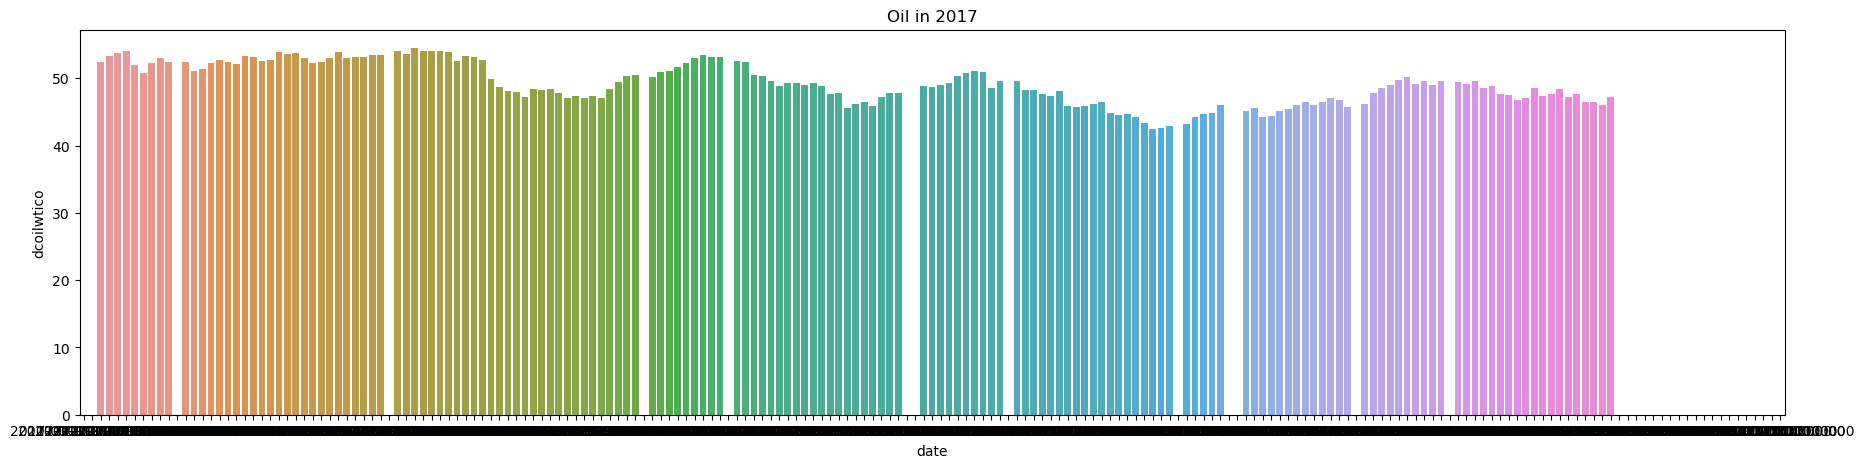

In [12]:
plt.figure(figsize=(22,5))

year = df[df['year'] == 2017]

oil_per_2017_year = year.groupby(['date'])['dcoilwtico'].sum()

sns.barplot(x=oil_per_2017_year.index.unique(), y=oil_per_2017_year)
plt.title('Oil in 2017')

Text(0.5, 1.0, 'Oil by year')

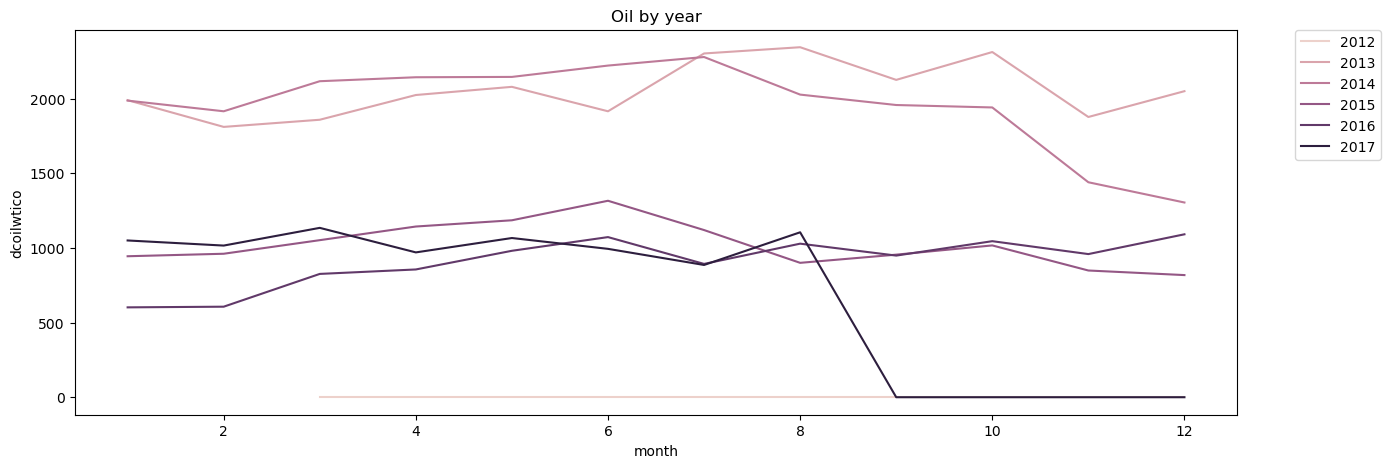

In [13]:
oil_per_year = df.groupby(['year','month'])['dcoilwtico'].sum()

oil_per_year = pd.DataFrame(oil_per_year)
oil_per_year = oil_per_year.reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=oil_per_year, x=oil_per_year['month'], y=oil_per_year['dcoilwtico'],hue=oil_per_year['year'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Oil by year')

In [14]:
types_mode = df['type'].value_counts().idxmax()
locale_mode = df['locale'].value_counts().idxmax()
locale_name_mode = df['locale_name'].value_counts().idxmax()
description_mode = df['description'].value_counts().idxmax()
transferred_mode = df['transferred'].value_counts().idxmax()

df.loc[df['type'].isna(), 'type'] = types_mode
df.loc[df['locale'].isna(), 'locale'] = locale_mode
df.loc[df['locale_name'].isna(), 'locale_name'] = locale_name_mode
df.loc[df['description'].isna(), 'description'] = description_mode
df.loc[df['transferred'].isna(), 'transferred'] = transferred_mode

df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24


Text(0.5, 1.0, 'Type by month')

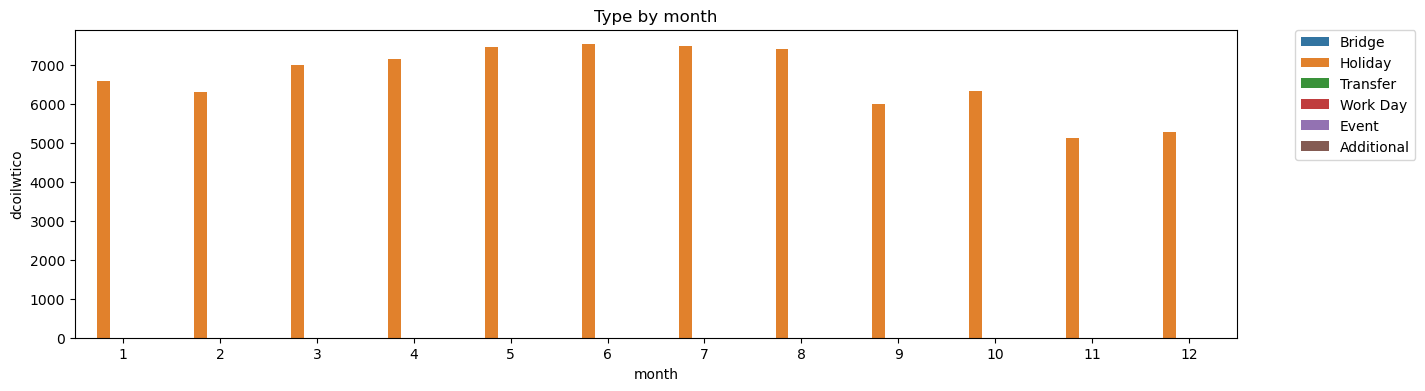

In [15]:
type_by_month_count = df.groupby(['month', 'type'])['dcoilwtico'].sum()
type_by_month_count = type_by_month_count.reset_index()

plt.figure(figsize=(15,4))
sns.barplot(data=type_by_month_count, x=type_by_month_count['month'], y=type_by_month_count['dcoilwtico'], hue=type_by_month_count['type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Type by month')

# Feature engineering/Cleaning

In [16]:
oil_nans = df[df['dcoilwtico'].isna()]

oil_nans_by_month = df[df['dcoilwtico'].isna()]['month']
months_with_oil_nan = oil_nans_by_month.unique()

average_oil_by_month = []

for i in months_with_oil_nan:
    month_vals = df[df['month'] == i]
    total_oil = month_vals['dcoilwtico'].sum()
    average = round((total_oil/len(month_vals)), 2)
    average_oil_by_month.append((i, average))

for i in range(len(months_with_oil_nan)):
    df = df.copy()
    df.loc[(df['month'] == average_oil_by_month[i][0]) & (df['dcoilwtico'].isna()), 'dcoilwtico'] = average_oil_by_month[i][1]

In [17]:
#df['dcoilwtico'] = df['dcoilwtico'].interpolate(method ='bfill')
df = df.interpolate(method ='linear')
df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,58.73,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,47.27,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,47.27,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,47.27,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,47.27,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,32.70,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,32.70,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,32.70,Additional,National,Ecuador,Navidad-1,False,12,2017,24


In [18]:
types = pd.get_dummies(df['type'])
locale = pd.get_dummies(df['locale'])
locale_name = pd.get_dummies(df['locale_name'])
transferred = pd.get_dummies(df['transferred'], drop_first=True)

df = pd.concat([df, types], axis=1)
df = pd.concat([df, locale], axis=1)
df = pd.concat([df, locale_name], axis=1)
df = pd.concat([df, transferred], axis=1)

df = df.drop(['type', 'locale', 'locale_name', 'description', 'transferred','day'], axis=1)

df = df.dropna()
df

,dcoilwtico,month,year,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
date,,,,,,,,,,,,,,,,,,,,,
2012-03-02,58.73,3,2012,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2012-04-01,47.27,4,2012,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-12,47.27,4,2012,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2012-04-14,47.27,4,2012,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2012-04-21,47.27,4,2012,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,32.70,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,32.70,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-24,32.70,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df[True] = df[True].astype('uint8')
df.columns = df.columns.map(str)

In [20]:
from sklearn.preprocessing import MinMaxScaler

train = df.loc[df.index < '2016-12-29']
test = df.loc[(df.index >= '2016-12-29')].drop('dcoilwtico', axis=1)
test_y = df.loc[(df.index >= '2016-12-29')]['dcoilwtico']

train = train.drop(train[train['year'] == 2012].index)

train = pd.DataFrame(train)
train = train.reset_index()
test = test.reset_index()
train = train.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})
test_x = test.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})

train.to_csv("train.csv", header=False, index=False)
test.to_csv("test.csv", header=False, index=False)

bucket = sagemaker.Session().default_bucket()

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
bucket
train

,ds,y,month,year,Additional,Bridge,Event,Holiday,Transfer,Work Day,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
0,2013-01-01,54.32,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,54.32,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-02,93.14,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-03,92.97,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-04,93.12,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,2016-12-25,32.70,12,2016,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1293,2016-12-26,32.70,12,2016,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,2016-12-26,32.70,12,2016,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1295,2016-12-27,52.82,12,2016,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
holidays = pd.DataFrame([
    {'holiday': 'shock_1', 'ds': '2017-08-01', 'lower_window': 0, 'ds_upper': '2017-12-30'},
])
for t_col in ['ds', 'ds_upper']:
    holidays[t_col] = pd.to_datetime(holidays[t_col])
holidays['upper_window'] = (holidays['ds_upper'] - holidays['ds']).dt.days
holidays

,holiday,ds,lower_window,ds_upper,upper_window
0,shock_1,2017-08-01,0,2017-12-30,151


In [22]:
model = Prophet()

columns = train.columns.drop(['y', 'ds'])

for i in columns:
    model.add_regressor(str(i))

model = model.fit(train)

forecast = model.predict(test_x)

14:09:21 - cmdstanpy - INFO - Chain [1] start processing
14:09:21 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
baseline = cross_validation(model, initial='1297 days', period='60 days', horizon = '10 days', parallel="processes")
df_p = performance_metrics(baseline, rolling_window=1)
df_p

14:09:22 - cmdstanpy - INFO - Chain [1] start processing
14:09:22 - cmdstanpy - INFO - Chain [1] start processing
14:09:22 - cmdstanpy - INFO - Chain [1] done processing
14:09:23 - cmdstanpy - INFO - Chain [1] done processing
14:09:23 - cmdstanpy - INFO - Chain [1] start processing
14:09:23 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,158.026165,12.570846,10.682381,0.251478,0.214975,0.308792,0.7


MAE is  9.612779866146976
MAPE is  0.2012203933255238


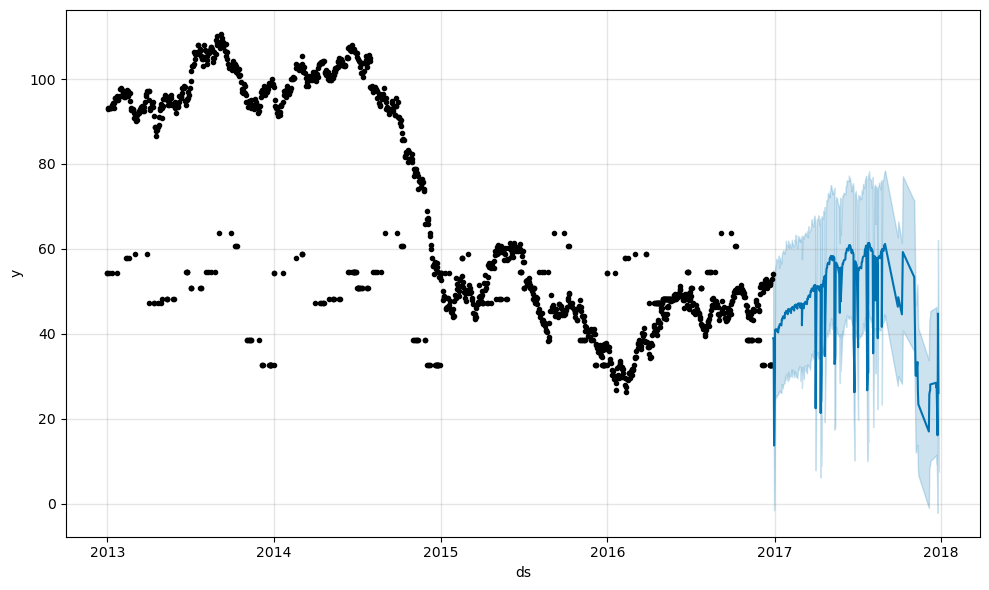

In [24]:
forecast_before = model.predict(test_x)

test_y = test_y.reset_index()

forecast_before['true'] = test_y['dcoilwtico']

mae = mean_absolute_error(forecast_before['true'], forecast_before['yhat'])
mape = mean_absolute_percentage_error(forecast_before['true'], forecast_before['yhat'])

print('MAE is ', mae)
print('MAPE is ', mape)

forecast_before[['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']]

plot_measure = model.plot(forecast_before)


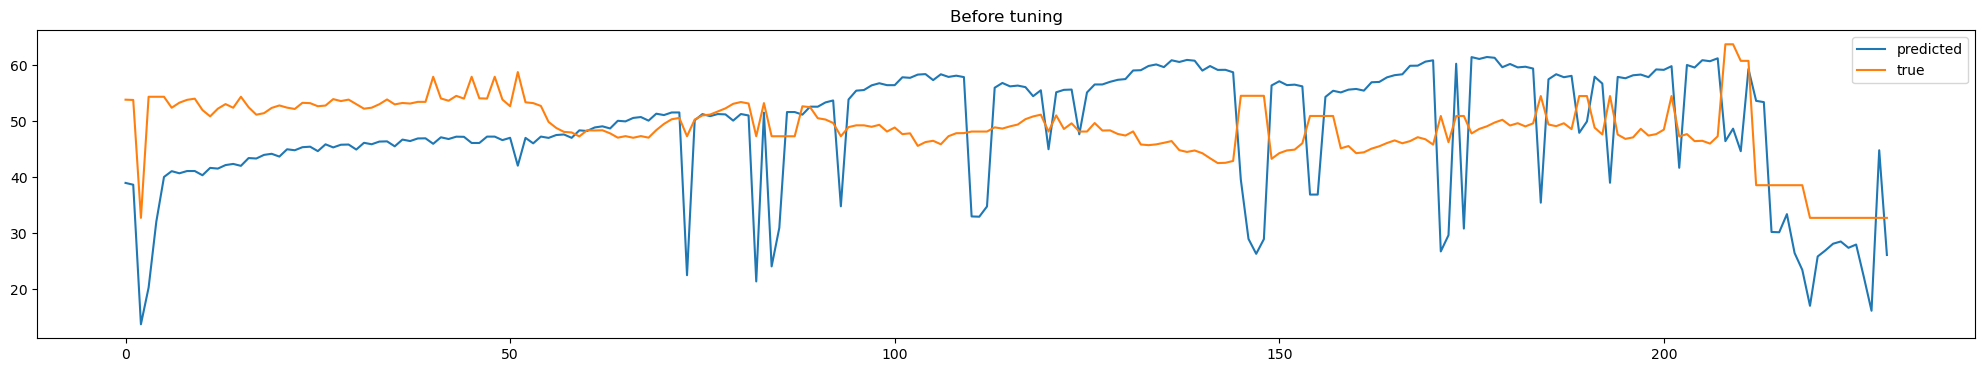

In [25]:
plt.figure(figsize=(25,4))
plt.plot(forecast_before['yhat'], label='predicted')
plt.plot(forecast_before['true'], label='true')
plt.legend()
plt.title('Before tuning')
plt.show()

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05,0.1],
    'seasonality_mode' : ['multiplicative'],
    'seasonality_prior_scale' : [25,35,45],
    'n_changepoints' : [20,30,35],
    'holidays_prior_scale' : [20,30,35]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    for i in columns:
        m.add_regressor(str(i))
    print(params)
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='1297 days', period='30 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])
    print(df_p['mape'].values[0])
    clear_output(wait=True)


# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

In [ ]:
best_params = all_params[np.argmin(mape)]
print(min(tuning_results['mape']))
print(best_params)

In [26]:
model = Prophet(changepoint_prior_scale=0.05,
                seasonality_prior_scale=25,
                n_changepoints=25,
                holidays_prior_scale=15,
                changepoint_range=0.7,
                seasonality_mode='multiplicative')

for i in columns:
    model.add_regressor(str(i))
    
model.fit(train)

14:09:24 - cmdstanpy - INFO - Chain [1] start processing
14:09:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,true,yhat_lower,yhat_upper
0,2016-12-29,45.480912,53.80,33.509004,57.294776
1,2016-12-30,45.345221,53.75,33.384706,57.656854
2,2016-12-31,32.731342,32.70,20.859948,45.140338
3,2017-01-01,37.574407,54.32,26.103240,50.486080
4,2017-01-02,39.078625,54.32,26.712836,50.921518


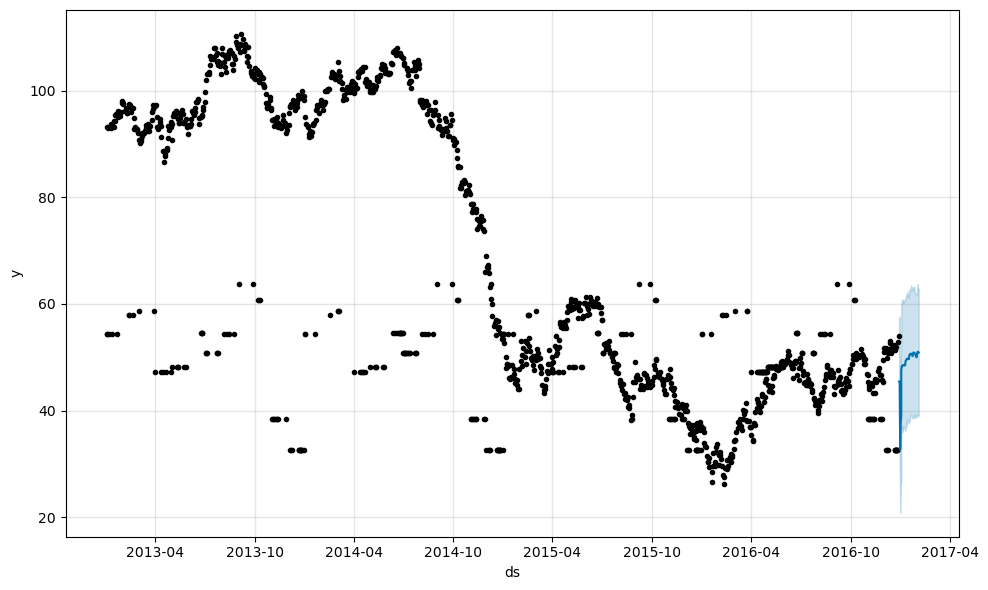

In [27]:
pd.set_option('display.max_rows', 500)
forecast = model.predict(test_x[:30])
forecast['true'] = test_y.iloc[:30]['dcoilwtico'].reset_index(drop=True)
mape = mean_absolute_percentage_error(forecast['true'], forecast['yhat'])

plot_measure = model.plot(forecast)
forecast[['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']].head()

In [28]:
mape = mean_absolute_percentage_error(forecast['true'], forecast['yhat'])
mae = mean_absolute_error(forecast['true'], forecast['yhat'])

print('MAPE is ', round(mape, 3))
print('MAE is ', round(mae,3))
test_y = test_y.reset_index()
forecast['true'] = test_y['dcoilwtico']

forecast [['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']].head()

MAPE is  0.076
MAE is  4.051


,ds,yhat,true,yhat_lower,yhat_upper
0,2016-12-29,45.480912,53.80,33.509004,57.294776
1,2016-12-30,45.345221,53.75,33.384706,57.656854
2,2016-12-31,32.731342,32.70,20.859948,45.140338
3,2017-01-01,37.574407,54.32,26.103240,50.486080
4,2017-01-02,39.078625,54.32,26.712836,50.921518


In [29]:
test_y = pd.DataFrame(test_y)
test_y = test_y.set_index('date')

train_copy = train.copy()
train_copy = train_copy.set_index('ds')
forecast_copy = forecast.copy()
forecast_copy = forecast_copy.set_index('ds')


<IPython.core.display.Javascript object>


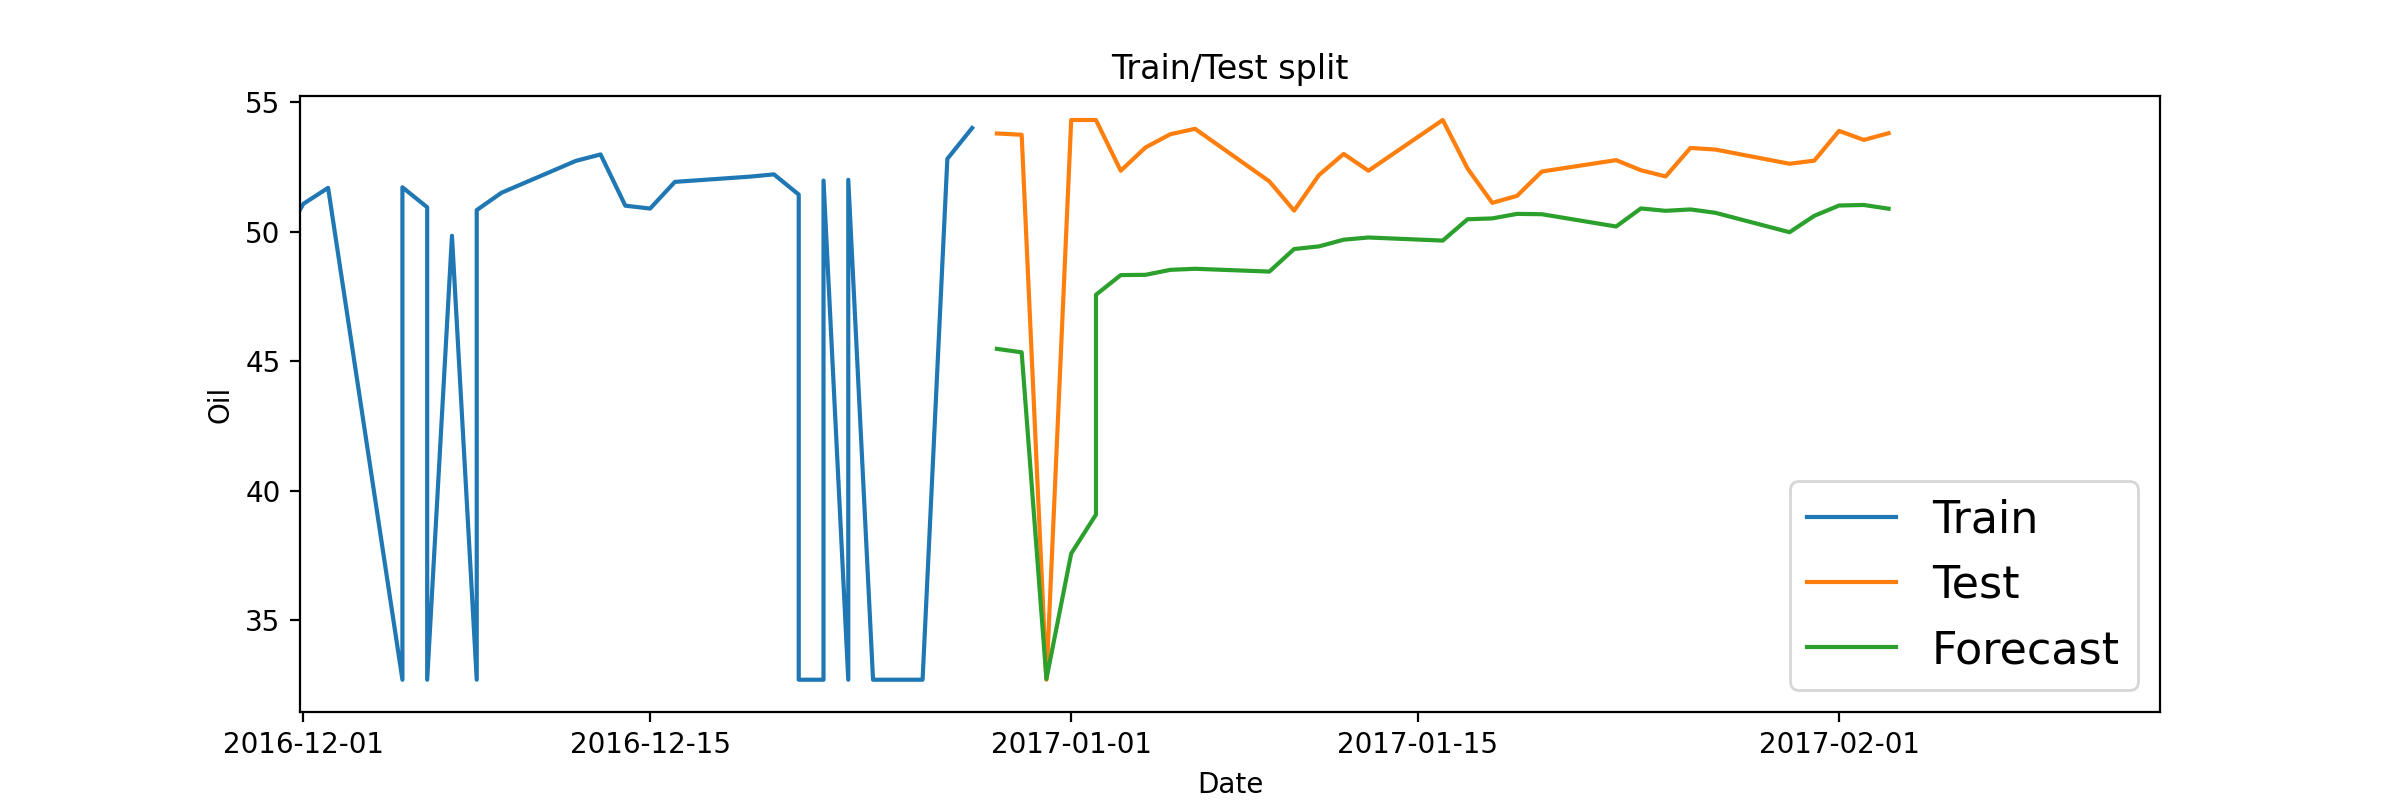

In [46]:
%matplotlib notebook

plt.figure(figsize=(12,4))
plt.plot(train_copy.index, train_copy['y'], label='Train')
plt.plot(test_y.index[:30], test_y['dcoilwtico'][:30], label='Test')
plt.plot(forecast_copy.index, forecast_copy['yhat'], label='Forecast')
plt.ylabel('Oil')
plt.xlabel('Date')
plt.title("Train/Test split")
plt.legend(prop={'size': 16})

plt.show()